# Optimisation du modèle XGBoost

Dans ce notebook, nous cherchons à optimiser notre modèle afin d’obtenir de meilleures performances pour la classe COVID.
Cette classe est particulièrement importante dans un contexte médical, où l’objectif est de maximiser la qualité des prédictions et de réduire au maximum les erreurs de classification.

## 📦 Importations des bibliothèques pour l'entraînement et l’optimisation du modèle XGBoost

Ce notebook utilise les bibliothèques suivantes pour :
- entraîner un modèle `XGBClassifier`
- optimiser un seuil de décision pour la classe COVID (classe 1)
- analyser les performances via les métriques et matrices de confusion
- visualiser les résultats
- sauvegarder le modèle final

In [682]:
from xgboost import XGBClassifier
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score, precision_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### 🔄 Chargement du split d'entraînement / test

Nous rechargeons ici les données pré-séparées (train / test) depuis le fichier `splits_128.pkl`.  
Ce split avait été sauvegardé auparavant pour garantir la reproductibilité des expériences.


In [683]:
split={}
filename=f"splits_{128}.pkl"
split=joblib.load(filename)

X_train,X_test,y_train,y_test=split["X_train"],split["X_test"],split["y_train"],split["y_test"]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8664, 2916)
(2166, 2916)
(8664,)
(2166,)


### ⚙️ Configuration du modèle XGBoost — Test de différents Learning Rates

Dans cette section, nous explorons une approche avancée basée sur un **planning du learning rate (LR scheduling)**.  
L’objectif initial était d’étudier comment une variation contrôlée du taux d’apprentissage pouvait améliorer la stabilité de la convergence et la qualité du modèle.

De nombreux essais de courbes de décroissance (`lr_decay`) ont été réalisés afin de trouver un compromis efficace entre vitesse d’apprentissage et capacité de généralisation.  
Cependant, faute de temps et au regard des performances obtenues, cette piste n’a pas été approfondie plus loin.

La suite du projet s’oriente finalement vers une optimisation différente, centrée sur :

- l’ajustement du `max_depth`,  
- la modification des **poids de la classe COVID** (amplification),  
- et la recherche d’un **seuil optimal F1** pour la classe 1.

Cette cellule reste néanmoins importante pour documenter les premières expérimentations.

Ce que nous préparons ici :

- Un planning `lr_decay` personnalisé sur 1000 itérations,  
- Un split *train/validation* stratifié,  
- Les `DMatrix` nécessaires à XGBoost,  
- Les paramètres de base du modèle,  
- Les callbacks : `EarlyStopping` et `LearningRateScheduler`.  


In [685]:
from xgboost import XGBClassifier

# Créer un dictionnaire vide pour récupérer les résultats
evals_result = {}

lr_decay = (
    [0.003]*60 +    # 0-59 : début très doux (lent mais utile)
    [0.005]*60 +    # 60-119 : léger accélération pour capter patterns
    [0.007]*100 +   # 120-219 : still slow, commencer la montée douce
    [0.006]*120 +   # 220-339 : baisse légère pour limiter gap (autour du 200-300)
    [0.004]*180 +   # 340-519 : fine-tuning intermédiaire
    [0.002]*240 +   # 520-759 : fine-tuning plus doux
    [0.001]*240     # 760-999 : ultra-fine tuning longue
)
# len(lr_decay) == 1000


x_train, x_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)


# DMatrix pour XGBoost
dtrain = xgb.DMatrix(x_train, label=Y_train)
dval   = xgb.DMatrix(x_val,   label=Y_val)

params = {
    "booster": "gbtree",
    "objective": "multi:softprob",
    "num_class": 3,
    "max_depth":3,
    "min_child_weight":15,
    "subsample": 0.8,          # sous-échantillonnage des lignes
    'colsample_bytree': 0.8,   # sous-échantillonnage des colonnes
    "colsample_bynode" : 0.8,
    "reg_lambda":5.0,
    "reg_alpha":1,
    "eval_metric": "mlogloss",
    }

# Callbacks
early_stop = xgb.callback.EarlyStopping(rounds=100,save_best=True)
lr_update=xgb.callback.LearningRateScheduler(learning_rates=lr_decay)


### 🚀 Entraînement du modèle avec planification du Learning Rate

Dans cette étape, nous entraînons un modèle XGBoost en utilisant :

- le **Learning Rate Scheduler** défini précédemment,
- un **early stopping** pour éviter le sur-apprentissage,
- un suivi des métriques d’entraînement et de validation via `evals_result`.

L’objectif était d’observer l’impact d’un planning détaillé du taux d’apprentissage sur la stabilité et la performance du modèle.

Le modèle est entraîné sur **1000 itérations potentielles**, mais `EarlyStopping` sélectionnera automatiquement le nombre optimal d’arbres.

In [126]:
xgb1=xgb.train(params ,
               dtrain=dtrain,
               num_boost_round = 1000,
               evals= [(dtrain, 'train'), (dval, 'val')],
               evals_result=evals_result,
               callbacks=[early_stop,lr_update],verbose_eval=50)

print(f"Meilleur nombre d'arbres : {xgb1.best_iteration}")

[0]	train-mlogloss:1.02607	val-mlogloss:1.03570
[50]	train-mlogloss:0.99701	val-mlogloss:1.01045
[100]	train-mlogloss:0.95867	val-mlogloss:0.97706
[150]	train-mlogloss:0.91517	val-mlogloss:0.93978
[200]	train-mlogloss:0.87433	val-mlogloss:0.90488
[250]	train-mlogloss:0.84305	val-mlogloss:0.87893
[300]	train-mlogloss:0.81757	val-mlogloss:0.85814
[350]	train-mlogloss:0.79656	val-mlogloss:0.84127
[400]	train-mlogloss:0.78274	val-mlogloss:0.83010
[450]	train-mlogloss:0.77001	val-mlogloss:0.82028
[500]	train-mlogloss:0.75796	val-mlogloss:0.81095
[550]	train-mlogloss:0.75012	val-mlogloss:0.80496
[600]	train-mlogloss:0.74470	val-mlogloss:0.80085
[650]	train-mlogloss:0.73939	val-mlogloss:0.79687
[700]	train-mlogloss:0.73418	val-mlogloss:0.79301
[750]	train-mlogloss:0.72914	val-mlogloss:0.78924
[800]	train-mlogloss:0.72613	val-mlogloss:0.78695
[850]	train-mlogloss:0.72368	val-mlogloss:0.78511
[900]	train-mlogloss:0.72126	val-mlogloss:0.78334
[950]	train-mlogloss:0.71888	val-mlogloss:0.78157
[99

### 📝 Commentaires — Évaluation du modèle XGBoost

- **Meilleur round (`best_iteration`)** : correspond au nombre d’arbres optimal trouvé par `early_stopping_rounds`.  
- **Meilleur score (`best_score`)** : c’est le meilleur *mlogloss* obtenu durant l’entraînement (plus bas = meilleur).

- Ensuite, on génère :
  - `y_prob` : les **probabilités prédites** pour chaque classe.
  - `y_pred` : la **classe prédite**, choisie par `argmax` (classe avec la probabilité la plus élevée).

- **Accuracy** : proportion de prédictions correctes sur l’ensemble de validation.

- **Matrice de confusion** (`pd.crosstab`) :  
  Permet de comparer les *vraies classes (`Y_val`)* avec les *classes prédites (`y_pred`)* afin d’identifier où le modèle se trompe.



In [129]:
# --- Meilleur round et score ---
print(f"Meilleur nombre d'arbres : {xgb1.best_iteration}")
print(f"Meilleur score (mlogloss) : {xgb1.best_score}")

# --- Prédictions ---
y_prob = xgb1.predict(dval)  # probabilités
y_pred = np.argmax(y_prob, axis=1)  # classes prédites

# --- Évaluation ---
acc = accuracy_score(Y_val, y_pred)
#ll = log_loss(Y_val, y_prob)
print(f"Accuracy : {acc}")
#print(f"Logloss : {ll}")
print(pd.crosstab(Y_val,y_pred),) 

Meilleur nombre d'arbres : 999
Meilleur score (mlogloss) : 0.7798561662031404
Accuracy : 0.6941719561454126
col_0    0    1    2
row_0               
0      446   82   65
1      105  405   69
2       79  130  352


### 📊 Évaluation — Classe COVID (1)

Matrice de confusion normalisée :

|       | Prédit 0 | Prédit 1 | Prédit 2 |
|-------|----------|----------|----------|
| Réel 0 | 0.752 | 0.138 | 0.110 |
| Réel 1 | 0.181 | 0.699 | 0.119 |
| Réel 2 | 0.141 | 0.232 | 0.627 |

**Classe COVID (1) :**  
- **Recall** : 0.699 → ~70% des vrais COVID détectés correctement.  
- Le modèle confond certains COVID avec les classes 0 et 2, mais le rappel reste prioritaire.  

Cette valeur servira de référence pour comparer avec la méthode optimisée.


In [368]:
print(pd.crosstab(Y_val,y_pred,normalize="index"))

col_0         0         1         2
row_0                              
0      0.752108  0.138280  0.109612
1      0.181347  0.699482  0.119171
2      0.140820  0.231729  0.627451


### 📈 Courbes d’apprentissage (Logloss)

Nous traçons l’évolution du **logloss** sur les ensembles **train** et **validation** pour visualiser la convergence du modèle au fil des itérations.

- L’axe **x** représente le nombre d’itérations (rounds).  
- L’axe **y** représente le **logloss**.  
- Les courbes permettent de détecter le surapprentissage et la stabilité de l’apprentissage.

```python
import matplotlib.pyplot as plt

plt.plot(evals_result["train"]["mlogloss"], label="Train")
plt.plot(evals_result["val"]["mlogloss"], label="Validation")
plt.xlabel("Round (approx)")
plt.ylabel("Logloss")
plt.legend()
plt.show()


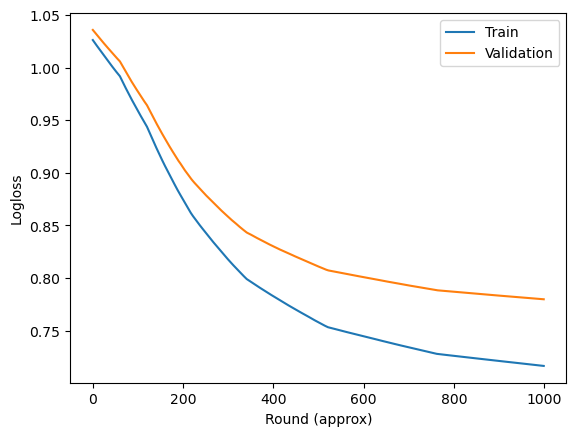

In [128]:
import matplotlib.pyplot as plt

plt.plot(evals_result["train"]["mlogloss"], label="Train")
plt.plot(evals_result["val"]["mlogloss"], label="Validation")
plt.xlabel("Round (approx)")
plt.ylabel("Logloss")
plt.legend()
plt.show()


### 📝 Conclusion de la première expérience (Learning Rate Scheduling)

Lors de cette première phase, nous avons exploré une **stratégie de variation dynamique du learning rate** (`lr_decay`) sur 1000 itérations afin d’observer son impact sur la convergence et la stabilité du modèle XGBoost.  

- Le modèle a atteint un **recall d’environ 0.70 pour la classe COVID** (classe 1), ce qui est correct mais insuffisant pour un usage médical critique.  
- Les courbes de logloss montrent que le modèle a convergé de manière stable vers un minimum commun.
- Cette approche a permis de **tester différentes vitesses d’apprentissage**, mais a été limitée par le temps et la complexité du planning de LR.  

➡️ Ces résultats motivent le passage à la **deuxième expérience**, centrée sur l’**optimisation du `max_depth` et l’amplification des poids** pour maximiser le F1 sur la classe COVID, plus adaptée à notre objectif médical.


---

### 🎯 Deuxième partie : Optimisation du modèle XGBoost pour la détection COVID (classe 1)

Lors de la première expérience avec **Learning Rate Scheduling**, nous avons testé différentes variations du taux d’apprentissage pour observer la convergence du modèle.  
Résultat : un **recall d’environ 0.70 pour la classe COVID (classe 1)**. Correct mais insuffisant pour un usage médical, car **trop de Faux Négatifs (FN)**.

---

#### ⚠️ Objectif médical

Un modèle pour détecter les positifs (COVID) doit respecter les priorités suivantes :

1. **Minimiser les Faux Négatifs (FN)**  
   - FN = vrais COVID non détectés → dangereux, priorité absolue.  
   - On cherche donc à **maximiser le recall** de la classe 1 :  
     
     Recall_1 = TP/TP + FN
     

2. **Limiter les Faux Positifs (FP)**  
   - FP = personnes non COVID détectées positives → gênant mais moins critique.  
   - On cherche à **augmenter la précision**, tout en tolérant quelques FP si cela réduit les FN.

---

#### ✅ Stratégie pour la deuxième expérience

- **Optimisation du `max_depth`** et **amplification des poids** pour la classe COVID.  
- Objectif : **maximiser le F1-score de la classe 1**, afin d’avoir un meilleur compromis **recall/précision**, plus de vrais positifs détectés, moins de FN et FP.  
- Cette approche permet de se concentrer sur la priorité médicale tout en conservant une bonne performance globale.


### ⚙️ Deuxième expérience : Optimisation via `max_depth` et amplification de la classe COVID

Dans cette étape, nous cherchons à améliorer la détection de la **classe COVID (classe 1)** en :

1. Testant différentes valeurs de `max_depth` pour le modèle XGBoost (3 à 7).  
2. Donnant plus de poids à la classe COVID lors de l’entraînement via un facteur `amp` ([1.5, 2.0, 2.5, 3.0]).  
   - Cette amplification permet de **favoriser la détection des vrais positifs** et de **réduire les Faux Négatifs (FN)**.

---

#### 🔹 Étapes réalisées pour chaque combinaison `(max_depth, amp)` :

- **Split train/validation** stratifié pour maintenir la proportion des classes.  
- **DMatrix XGBoost** avec **poids ajustés pour la classe COVID**.  
- **Entraînement du modèle** sur 300 arbres.  
- **Prédictions et évaluation** :
  - Matrice de confusion standard (seuil 0.5).  
  - Calcul du **recall, précision et F1-score** pour la classe COVID avec le seuil par défaut (0.5).  
- **Recherche du seuil optimal** qui maximise le F1-score pour la classe COVID via la courbe Precision-Recall.
  - Génération de la **matrice de confusion optimisée** et du **classification report** après optimisation.

---

#### 🔹 Stockage des résultats

Pour chaque combinaison `(max_depth, amp)` :

- `rec_default`, `prec_default`, `f1_default` → métriques avec seuil 0.5.  
- `best_thresh_f1` → seuil optimisé pour le F1 de la classe COVID.  
- `classification_F1` → classification report après optimisation.  
- `confusion_default` → matrice de confusion standard.  
- `confusion_opt_F1` → matrice de confusion après optimisation du seuil.


In [589]:
amps = [1.5, 2.0, 2.5, 3.0]

# Dictionnaire pour sauvegarder les matrices
conf_matrices = {}
probas_stock = {}   # pour stocker y_prob_amp
true_stock = {}     # pour stocker les vrais labels Y_val
results = {}

x_train, x_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)


# --- fonction utilitaire pour construire poids normalisés ---
def build_normalized_weights(y, amp_for_class1):
    w = np.ones(len(y), dtype=float)
    w[y == 1] = amp_for_class1
    # Normaliser pour que la moyenne des poids reste 1 (évite de changer l'échelle globale)
    w = w / np.mean(w)
    return w

    
for d in (3,4,5,6,7):
    params1 = {
    "booster": "gbtree",
    "objective": "multi:softprob",
    "num_class": 3,
    "max_depth":d,
    "min_child_weight":15,
    "subsample": 0.8,          # sous-échantillonnage des lignes
    'colsample_bytree': 0.8,   # sous-échantillonnage des colonnes
    "colsample_bynode" : 0.8,
    "reg_lambda":5.0,
    "reg_alpha":1,
    "eval_metric": "mlogloss",
    "eta":0.1,
    "seed": 42, # resultats reproductible
    "nthread": 1 # resultats séquentiel 
    }


    
    for amp in amps:
        print("\n---- Test amp =", amp," pour max_depth=",d)
    
                                                  
        # -- DMatrix --
        sample_weights=build_normalized_weights(Y_train,amp)
        dtrain_amp = xgb.DMatrix(x_train, label=Y_train, weight=sample_weights)
        dval_amp   = xgb.DMatrix(x_val, label=Y_val)
    
        # -- Train 300 tree --
        model_amp = xgb.train(params1, dtrain_amp, num_boost_round=300, verbose_eval=False)
    
        # -- Prédictions --
        y_prob_amp = model_amp.predict(dval_amp)
        y_pred_amp = np.argmax(y_prob_amp, axis=1)
    
        # -- Classe 1 : vrais & prédits --
        true_cls1 = (Y_val == 1).astype(int)
        
      
             
        # -- Matrice de confusion --
        conf_mat = pd.crosstab(Y_val, y_pred_amp, normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"])
        print("Confusion matrix standard:\n", conf_mat)

        # default predictions at 0.5
        y1_pred_default = (y_prob_amp[:, 1] >= 0.5).astype(int)
        rec = recall_score(true_cls1, y1_pred_default)
        prec = precision_score(true_cls1, y1_pred_default)
        f1 = f1_score(true_cls1, y1_pred_default)

        # threshold tuning (meilleur F1) -via PRC plusieurs seuil sont testé pour determiner le meilleur f1 et ensuite recuperer 
        # index du meilleur f1 et recupere le meilleur seuil via l'index ths[best_idx]
        precs, recs, ths = precision_recall_curve(true_cls1, y_prob_amp[:, 1])

        f1s = 2 * (precs * recs) / (precs + recs + 1e-12)  # Calcul des F1 pour chaque seuil

        # 3️⃣ Seuil qui maximise F1
        best_idx_f1 = np.nanargmax(f1s) # Index du meilleur F1
        best_thresh_f1 = ths[best_idx_f1] if best_idx_f1 < len(ths) else 0.5 # On vérifie que l'index best_idx est valide dans ths(contenu),
                                                                             # sinon on utilise un seuil par défaut

        #Classification report 
        Report_F1=classification_report(Y_val, np.where(y_prob_amp[:, 1]>=best_thresh_f1, 1, y_pred_amp),digits=3,output_dict=True)
      
        results[(d, amp)] = {
        "rec_default": rec, 
        "prec_default": prec, 
        "f1_default": f1,
        "best_thresh_f1": float(best_thresh_f1),
        "classification_F1":Report_F1,
        "confusion_default": pd.crosstab(Y_val, y_pred_amp,normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"]),
        "confusion_opt_F1": pd.crosstab(Y_val, np.where(y_prob_amp[:, 1]>=best_thresh_f1, 1, y_pred_amp),normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"])}
       
       # -- Sauvegarde --
        conf_matrices[(d, amp)] = conf_mat
        probas_stock[(d, amp)] = y_prob_amp
        true_stock[(d, amp)] = Y_val

    



---- Test amp = 1.5  pour max_depth= 3
Confusion matrix standard:
 Classe prédite         0         1         2
Classe réelle                               
0               0.779896  0.169844  0.050260
1               0.119377  0.785467  0.095156
2               0.089965  0.185121  0.724913

---- Test amp = 2.0  pour max_depth= 3
Confusion matrix standard:
 Classe prédite         0         1         2
Classe réelle                               
0               0.755633  0.207972  0.036395
1               0.093426  0.837370  0.069204
2               0.081315  0.226644  0.692042

---- Test amp = 2.5  pour max_depth= 3
Confusion matrix standard:
 Classe prédite         0         1         2
Classe réelle                               
0               0.715771  0.240901  0.043328
1               0.088235  0.861592  0.050173
2               0.070934  0.269896  0.659170

---- Test amp = 3.0  pour max_depth= 3
Confusion matrix standard:
 Classe prédite         0         1         2
Classe r

# Visualisation des matrices de confusion optimisées F1 pour toutes les combinaisons max_depth et amplification

### 🔹 Visualisation des performances par combinaison `max_depth` × amplification

Cette cellule affiche les **matrices de confusion normalisées** après optimisation du F1-score pour la **classe COVID (classe 1)**.  
Chaque heatmap correspond à une combinaison spécifique de :

- `max_depth` : profondeur maximale de l'arbre XGBoost  
- `amp` : facteur d'amplification du poids de la classe COVID

L'objectif est de **comparer visuellement l'impact de ces paramètres** sur la détection des différentes classes.


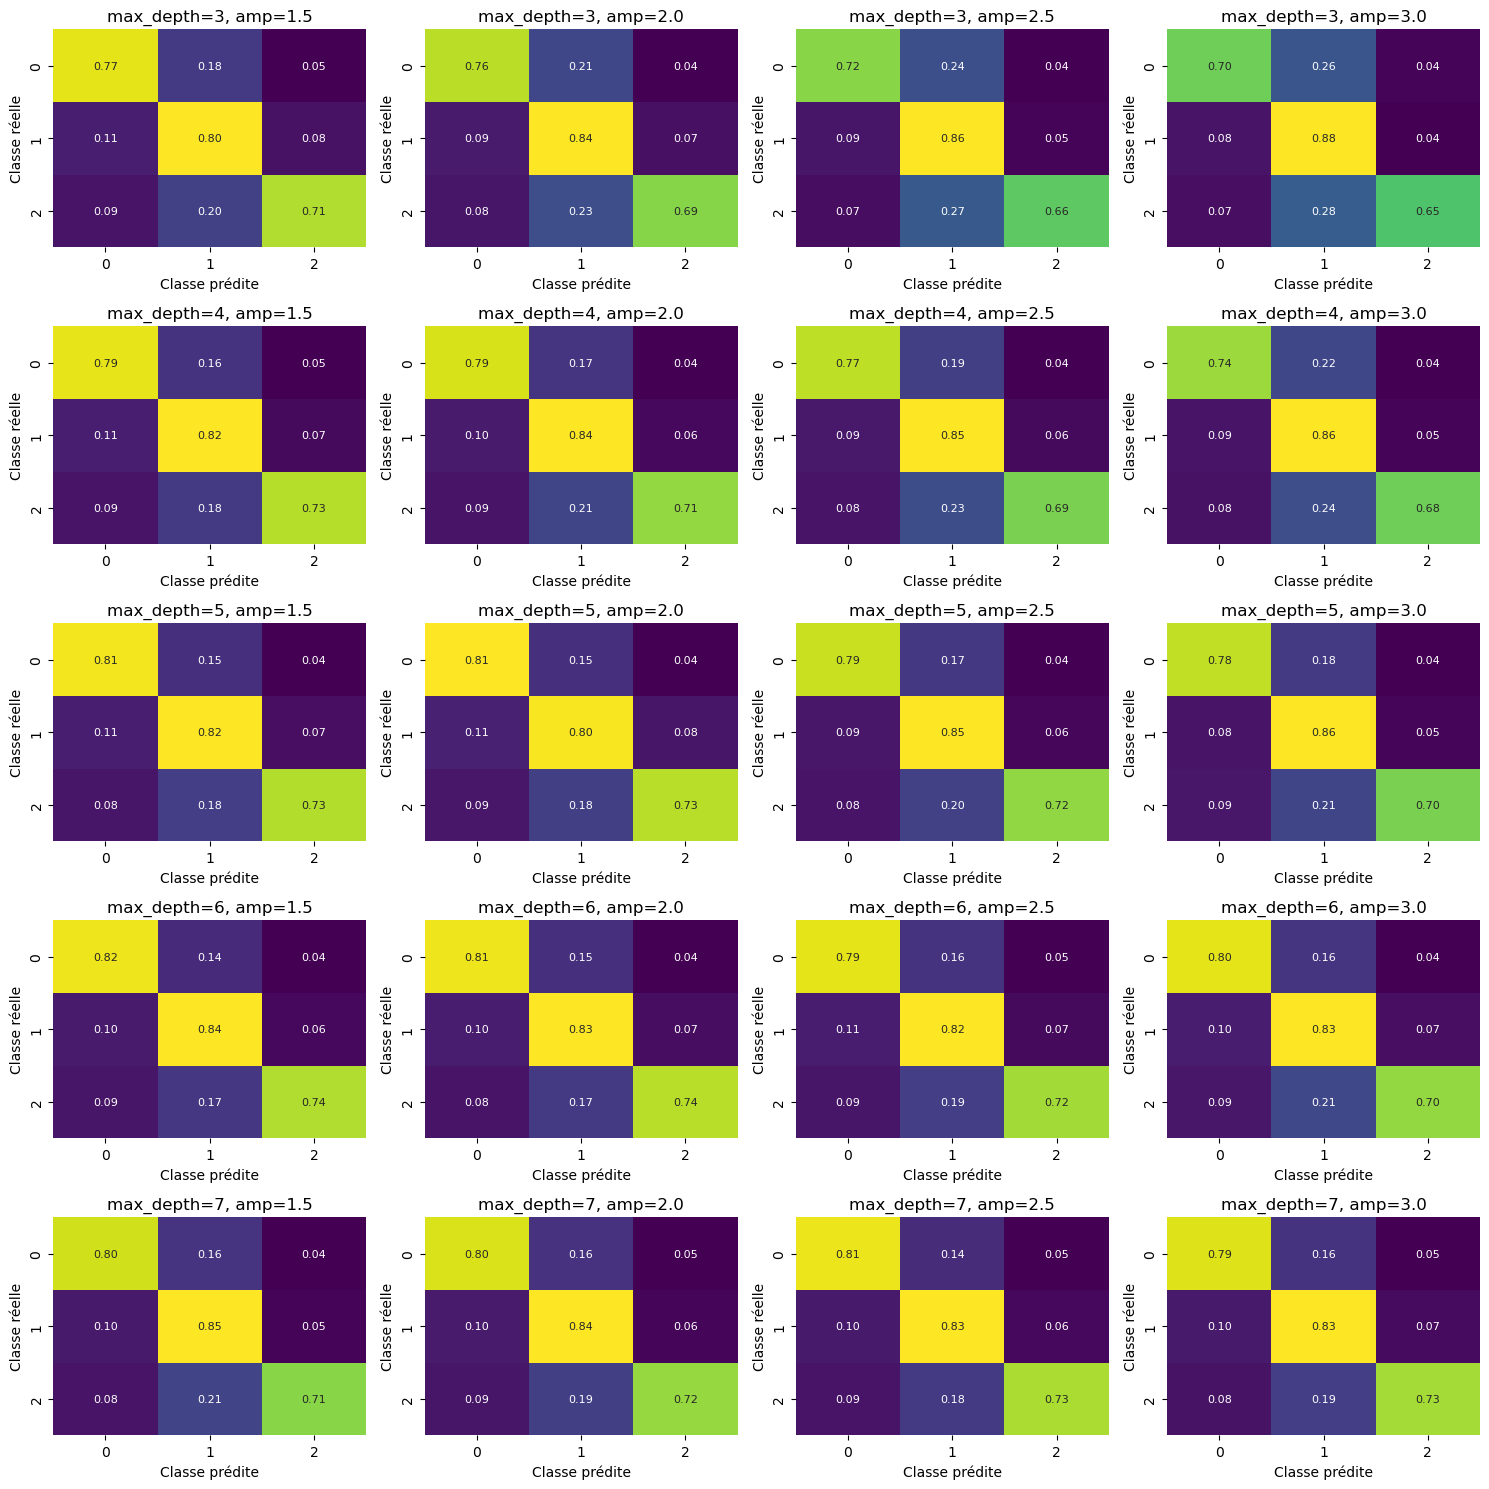

In [632]:
import matplotlib.pyplot as plt
import seaborn as sns

amps = [1.5, 2.0, 2.5, 3.0]
depths = range(3, 8)  # 3,4,5,6,7

fig, axes = plt.subplots(len(depths), len(amps), figsize=(15, 15))  # 5 lignes × 4 colonnes

for i, d in enumerate(depths):         # lignes
    for j, amp in enumerate(amps):    # colonnes
        sns.heatmap(results[(d, amp)]["confusion_opt_F1"], annot=True, fmt=".2f", ax=axes[i, j], cmap="viridis",cbar=False,annot_kws={"size": 8})
        axes[i, j].set_title(f"max_depth={d}, amp={amp}")
        axes[i, j].set_xlabel("Classe prédite")
        axes[i, j].set_ylabel("Classe réelle")

plt.tight_layout()
plt.show()


# Sélection de la combinaison optimale max_depth × amplification pour maximiser le F1 de la classe COVID

### 🔹 Identification de la meilleure combinaison de paramètres

Cette cellule recherche la **combinaison de `max_depth` et du facteur d'amplification (`amp`)** qui fournit le **F1-score le plus élevé pour la classe COVID (classe 1)**, tout en conservant des scores corrects pour les autres classes.

Étapes réalisées :

- Création d’un DataFrame regroupant **precision, recall et F1-score** pour chaque classe et chaque combinaison.  
- Filtrage des combinaisons qui assurent un F1 ≥ 0.75 pour toutes les classes.  
- Tri des résultats pour **maximiser le F1 de la classe COVID (classe 1)**.  
- Extraction des **paramètres optimaux** : `depth_best`, `amp_best`, et `best_thresh`.  

Le résultat permet de déterminer **la meilleure configuration pour la détection COVID avec F1 maximal**.


In [638]:
row=[]
for (d,amp),val in results.items():
    report = val["classification_F1"]
   
    entry={"depth":d,"amp":amp,"best_thresh_f1":val["best_thresh_f1"]}
    for cls in ("0","1","2"):
        entry[f"precision_{cls}"]=report[cls]["precision"]
        entry[f"recall_{cls}"]=report[cls]["recall"]
        entry[f"score_{cls}"]=report[cls]["f1-score"]
        
    row.append(entry)

resultat=pd.DataFrame(row)

resultat_best_comb=resultat[(resultat["score_0"]>=0.75) & (resultat["score_1"]>=0.75) & (resultat["score_2"]>=0.75)].sort_values(by="score_1",ascending=False).head(1).copy()
depth_best=resultat_best_comb["depth"].iloc[0]
amp_best=resultat_best_comb["amp"].iloc[0]
best_thresh=resultat_best_comb["best_thresh_f1"].iloc[0]

resultat_best_comb


,depth,amp,best_thresh_f1,precision_0,recall_0,score_0,precision_1,recall_1,score_1,precision_2,recall_2,score_2
12,6,1.5,0.412406,0.810997,0.818024,0.814495,0.731118,0.83737,0.780645,0.877301,0.742215,0.804124


# Entraînement du modèle XGBoost avec la combinaison optimale max_depth(6) et amplification(1.5) de la classe COVID

### 🔹 Entraînement du modèle optimal avec la combinaison `max_depth` et amplification de la classe COVID

Dans cette cellule, nous entraînons le modèle XGBoost avec la **meilleure combinaison de paramètres** identifiée précédemment (`max_depth` et facteur d’amplification `amp`) pour la **classe COVID (classe 1)**.

**Points clés :**

- **Split train/validation** stratifié pour garantir la proportion des classes.  
- **Poids normalisés** pour la classe COVID afin de favoriser la détection des vrais positifs :  
  - La classe 1 voit son poids multiplié par `amp` et normalisé pour conserver la moyenne globale à 1.  
- **Entraînement sur 300 arbres** avec paramètres optimisés pour la stabilité et reproductibilité :  
  - `random_state` (`seed=42`) pour garantir la reproductibilité.  
  - `nthread=1` pour désactiver le calcul parallèle et éviter des variations non désirées.
- **Prédictions et évaluation** :
  - Matrice de confusion standard (seuil 0.5) et matrice optimisée via le seuil F1 pré-calculé.  
  - `classification_report` avant et après optimisation.
- **Stockage des résultats** dans des dictionnaires pour consultation et visualisation ultérieure.


In [640]:
# Dictionnaires pour sauvegarde
conf_matrices = {}
probas_stock = {}   # pour stocker y_prob_amp
true_stock = {}     # pour stocker les vrais labels Y_val
results_best = {}
models = {}  


# Split reproductible et stratifié
x_train, x_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

# Récupération de la meilleure combinaison
best_combi=resultat_best_comb[["depth","amp","best_thresh_f1"]].copy()


# --- Fonction pour générer des poids normalisés ---
def build_normalized_weights(y, amp_for_class1):
    w = np.ones(len(y), dtype=float)
    w[y == 1] = amp_for_class1
    return w / np.mean(w) # Normalisation pour garder une moyenne = 1

# ===============================
#   ENTRAÎNEMENT DU MODÈLE OPTIMAL
# ===============================

d = int(resultat_best_comb["depth"].iloc[0])
amp = float(resultat_best_comb["amp"].iloc[0])
seuil = float(resultat_best_comb["best_thresh_f1"].iloc[0])


params1 = {
"booster": "gbtree",
"objective": "multi:softprob",
"num_class": 3,
"max_depth":d,
"min_child_weight":15,
"subsample": 0.8,          # sous-échantillonnage des lignes
'colsample_bytree': 0.8,   # sous-échantillonnage des colonnes
"colsample_bynode" : 0.8,
"reg_lambda":5.0,
"reg_alpha":1,
"eval_metric": "mlogloss",
"eta":0.1,
"seed": 42, # resultats reproductible
"nthread": 1 # resultats séquentiel
        }




print(f"\n---- Entraînement modèle pour amp={amp}, depth={d} ----")

                                          
# Construction du DMatrix avec poids normalisés
sample_weights=build_normalized_weights(Y_train,amp)
dtrain_amp = xgb.DMatrix(x_train, label=Y_train, weight=sample_weights)
dval_amp   = xgb.DMatrix(x_val, label=Y_val)

# Entraînement du modèle
model=xgb.train(params1, dtrain_amp, num_boost_round=300, verbose_eval=False)


# -- Prédictions 
y_prob_amp = model.predict(dval_amp)
y_pred_amp = np.argmax(y_prob_amp, axis=1)


# Prédictions optimisées via seuil F1 pré-calculé
y_pred_opt = np.where(y_prob_amp[:,1] >= seuil, 1, y_pred_amp)

# Matrices de confusion normalisées
conf_mat_avant_opt=pd.crosstab(Y_val, y_pred_amp,normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"])
conf_mat_opt=pd.crosstab(Y_val, y_pred_opt,normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"])

# Classification reports 
Report=classification_report(Y_val, y_pred_amp,digits=3)
Report_best=classification_report(Y_val, y_pred_opt,digits=3)


# Stockage des résultats
results_best[(d,amp)] = {
    "best_thresh_F1": float(seuil),
    "classification": Report,
    "classification_best": Report_best,
    "confusion": conf_mat_avant_opt,
    "confusion_best": conf_mat_opt
}


# Sauvegarde
conf_matrices[(d, amp)] = conf_mat_opt
probas_stock[(d, amp)] = y_prob_amp
true_stock[(d, amp)] = Y_val
models[(d, amp)] = model

  



---- Entraînement modèle pour amp=1.5, depth=6 ----


# Comparaison des matrices de confusion — Avant vs Après optimisation F1

Cette cellule affiche deux heatmaps pour visualiser l'effet de l'optimisation du seuil F1 sur la classe COVID (classe 1) :

- **Heatmap du haut :** matrice de confusion standard avec le seuil par défaut (0.5).  
- **Heatmap du bas :** matrice de confusion après application du seuil optimisé pour maximiser le F1-score de la classe COVID.  

L'objectif est d'observer l'amélioration de la détection des vrais positifs (classe 1) tout en maintenant une performance équilibrée pour les autres classes.


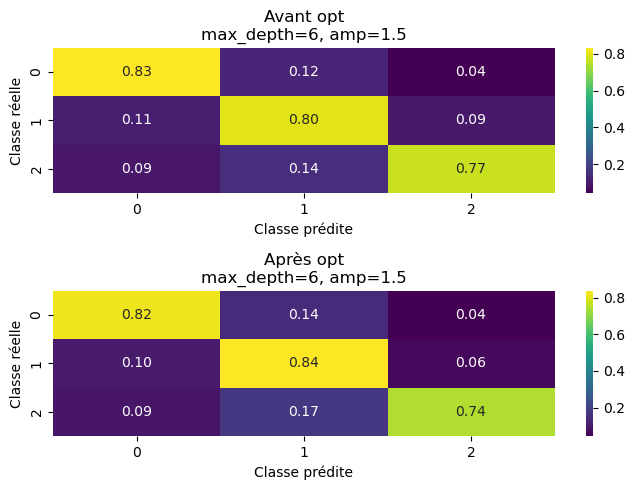

In [653]:
fig, axes = plt.subplots(2, 1, figsize=(7, 5))

    
# Récupération de la matrice optimisée et basique
mat_opt = results_best[(d, amp)]["confusion_best"]
mat = results_best[(d, amp)]["confusion"]

best_thresh_F1 = results_best[(d, amp)]["best_thresh_F1"]

# Heatmap avant optimisation (ligne du haut)
sns.heatmap(mat, annot=True, fmt=".2f", cmap="viridis", ax=axes[0])
axes[0].set_title(f"Avant opt\nmax_depth={d}, amp={amp}")
axes[0].set_xlabel("Classe prédite")
axes[0].set_ylabel("Classe réelle")

# Heatmap après optimisation (ligne du bas)
sns.heatmap(mat_opt, annot=True, fmt=".2f", cmap="viridis", ax=axes[1])
axes[1].set_title(f"Après opt\nmax_depth={d}, amp={amp}")
axes[1].set_xlabel("Classe prédite")
axes[1].set_ylabel("Classe réelle")



plt.tight_layout()
plt.show()





### 🔹 Résultats sur les données de validation

Nous comparons ici le **classification report** avant et après l'application du seuil optimisé pour maximiser le F1-score de la classe COVID (classe 1) :

In [657]:
print(results_best[(d, amp)]["classification"])


print(results_best[(d, amp)]["classification_best"])

              precision    recall  f1-score   support

           0      0.807     0.832     0.819       577
           1      0.748     0.798     0.772       578
           2      0.849     0.766     0.805       578

    accuracy                          0.799      1733
   macro avg      0.801     0.799     0.799      1733
weighted avg      0.801     0.799     0.799      1733

              precision    recall  f1-score   support

           0      0.811     0.818     0.814       577
           1      0.731     0.837     0.781       578
           2      0.877     0.742     0.804       578

    accuracy                          0.799      1733
   macro avg      0.806     0.799     0.800      1733
weighted avg      0.806     0.799     0.800      1733



### 🎯 Analyse des résultats — Optimisation du seuil F1 pour la classe COVID (classe 1)

L'optimisation du seuil a modifié le compromis entre **recall** et **précision** pour la classe COVID :

#### 📌 Recall (sensibilité) — détecter les vrais positifs
- Avant optimisation : 79.8%
- Après optimisation : 83.7%
- ✅ Augmentation significative : on détecte **plus de vrais COVID**.
- 🔹 Interprétation : moins de vrais cas COVID sont envoyés en classe 0 ou 2 → les Faux Négatifs diminuent. (FN).
- 💡 Conclusion : le modèle confond moins les vrais positifs avec les autres classes.

#### 📌 Précision — fiabilité quand on prédit "1"
- Avant optimisation : 74.8%
- Après optimisation : 73.1%
- ⚠ Légère diminution : Légère diminution : le seuil, inférieur à 0.5, devient plus permissif → cela génère davantage de Faux Positifs (FP).
- 🔹 Interprétation : comme la classe “1” est plus facilement attribuée, certains échantillons négatifs sont faussement considérés comme COVID.

#### 🔍 Bilan pour la classe COVID
- Recall ↑ → plus de vrais positifs détectés → **moins de Faux Négatifs (FN)**
- Précision ↓ → un peu plus de faux positifs (FP)
- ✅ F1-score ↑ → meilleur compromis global

#### 💡 Résumé en une phrase
Le modèle **détecte beaucoup mieux la classe COVID (83% des vrais 1 trouvés)**, au prix d’une **légère augmentation des fausses alertes**.  
C’est exactement ce qu’on recherche pour un usage médical : **priorité à détecter les vrais positifs et minimiser les Faux Négatifs**.

#### ⚠ Comparaison avec le premier test (`lr_decay`)
- Recall initial avec LR scheduling : ~70%
- Recall après optimisation via poids + seuil F1 : 83.7%
- ✅ Conclusion : cette deuxième expérience est **nettement plus efficace** pour la détection des cas COVID.


# prediction sur le jeu test sur le model XGBoost optimisé

Dans cette étape, nous utilisons le **modèle entraîné avec la combinaison optimale (max_depth et amplification de la classe COVID)** pour générer des prédictions sur les données de test (`X_test`).  

- **Prédiction basique** : classe avec la probabilité maximale (`argmax`).  
- **Prédiction optimisée** : ajustement du seuil pour la classe COVID (classe 1) selon le `seuil` trouvé précédemment pour maximiser le F1-score.

In [660]:
y_prob_test = model.predict(xgb.DMatrix(X_test))


# prédiction basique
y_test_pred_base = np.argmax(y_prob_test, axis=1)

# prédiction optimisée
y_test_pred_opt = np.where(y_prob_test[:, 1] >= seuil,1,y_test_pred_base)


### 📊 Évaluation du modèle sur le jeu de test

Dans cette cellule, on compare les performances du modèle **avant** et **après optimisation du seuil** pour la classe COVID (classe 1).  
L’objectif est d’observer comment l’ajustement du seuil modifie la précision, le rappel et le F1-score sur les données jamais vues.

- **Avant optimisation** → prédiction classique via `argmax`  
- **Après optimisation** → seuil personnalisé pour améliorer le rappel/F1 de la classe COVID

Les rapports suivants permettent de visualiser l’impact réel de cette optimisation sur le jeu de test.


In [695]:
from sklearn.metrics import classification_report,confusion_matrix

print("=== Test — Avant optimisation ===")
#Classification report
print(classification_report(y_test, y_test_pred_base, digits=3))

#Matrice de confusion normalisée
print(pd.crosstab(y_test, y_test_pred_base,normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"]))
print("\n")


print("=== Test — Après optimisation ===")
#Classification report
print(classification_report(y_test, y_test_pred_opt, digits=3))

#Matrice de confusion normalisée
print(pd.crosstab(y_test, y_test_pred_opt,normalize="index",rownames=["Classe réelle"],colnames=["Classe prédite"]))


=== Test — Avant optimisation ===
              precision    recall  f1-score   support

           0      0.790     0.814     0.802       722
           1      0.712     0.776     0.742       722
           2      0.839     0.738     0.786       722

    accuracy                          0.776      2166
   macro avg      0.780     0.776     0.777      2166
weighted avg      0.780     0.776     0.777      2166

Classe prédite         0         1         2
Classe réelle                               
0               0.814404  0.132964  0.052632
1               0.135734  0.775623  0.088643
2               0.080332  0.181440  0.738227


=== Test — Après optimisation ===
              precision    recall  f1-score   support

           0      0.802     0.798     0.800       722
           1      0.693     0.813     0.748       722
           2      0.859     0.715     0.780       722

    accuracy                          0.775      2166
   macro avg      0.785     0.775     0.776      216


---

#### 🔹 Interprétation

- **Classe COVID (1)** : le **recall** augmente de 77.6% → 81.3%, ce qui signifie que le modèle détecte **plus de vrais positifs** (réduction des FN).  
- La **précision** diminue légèrement de 71.2% → 69.3%, entraînant une légère augmentation des FP, mais c’est un compromis acceptable pour maximiser le rappel médical.  
- Les autres classes (0 et 2) subissent de légères variations, mais la performance globale reste stable.  
- **Conclusion** : l’optimisation du seuil améliore significativement la détection de la classe COVID, tout en gardant un compromis global satisfaisant.


### 💾 Sauvegarde du modèle optimisé et du seuil F1

Dans cette cellule, nous sauvegardons :

- Le modèle XGBoost entraîné avec la **meilleure combinaison** `(max_depth, amp)`.  
- Le **seuil F1 optimal** utilisé pour la prédiction de la classe COVID (classe 1).  

Nous utilisons `joblib` pour permettre une **recharge ultérieure** du modèle et du seuil sans avoir à réentraîner.


In [696]:
import joblib

# Sauvegarde du modèle
joblib.dump(model, "xgb_model_best.joblib")

# Sauvegarde du seuil optimal
joblib.dump(best_thresh, "best_thresh.joblib")


['best_thresh.joblib']

### 🎯 Conclusion générale

Dans ce projet, nous avons mené **deux expériences principales** pour optimiser la détection de la classe COVID (classe 1) :

1. **Première expérience** : Learning Rate Scheduling  
   - Recall sur la classe 1 ≈ 70%  
   - Correct mais insuffisant pour un usage médical (trop de Faux Négatifs).

2. **Deuxième expérience** : Optimisation via `max_depth` et amplification de la classe COVID  
   - Recall sur la classe 1 ≈ 83,7%  
   - Légère baisse de précision mais augmentation du F1-score → amélioration réelle.  
   - Accuracy globale stable → le modèle n’est pas moins performant pour les autres classes.

---

#### 🔹 Bilan

- **Classe 1 (COVID)** : beaucoup mieux détectée, moins de FN → priorités médicales respectées.  
- **Classes 0 et 2** : légères variations normales, car quelques échantillons sont “capturés” par la classe 1.  
- **Compromis** : Recall ↑, Précision ↓ légèrement, F1 ↑ → compromis logique et maîtrisé.  
- **Rappel** : pour le domaine médical, un recall supérieur à 80% est correct mais on peut encore l’améliorer.

---

### 🔹 Perspectives et Conclusion finale

**Perspectives**

Avec plus de temps et de recul, il serait intéressant d’explorer des approches **Deep Learning**, notamment :  
- Transfert Learning sur des architectures pré-entraînées.  
- Modification des dernières couches pour mieux adapter le modèle à la détection de COVID.  

Ces approches pourraient permettre d’**augmenter encore le recall** et d’obtenir un modèle plus **stable et fiable**.

**Conclusion finale**

La seconde expérience montre une amélioration claire par rapport à la première, avec une progression du **recall COVID d’environ 70% à 83,7%**. Cette avancée confirme que l’optimisation du seuil et des paramètres du modèle peut réellement améliorer la détection des cas COVID.

Le projet reste très prometteur, mais pour atteindre un niveau de performance pleinement adapté au domaine médical, il nécessiterait :  
- plus de temps,  
- plus de recul sur les données,  
- plus d’expérience dans l’ajustement fin des modèles,  
- et éventuellement l’exploration de méthodes **Deep Learning** (ex. transfert learning) qui pourraient apporter un gain supplémentaire en capacité de généralisation.

Avec des jeux de données plus grands et un affinement continu, les performances pourraient encore être améliorées de manière significative.

